In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
import gc

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [ ]:
dataset1 = load_dataset("opus100", "en-hi")
df1_train = pd.DataFrame(dataset1['train']['translation'],columns=['en','hi'])
df1_train.rename(columns={'en':'lang1','hi':'lang2'},inplace=True)
df1_val = pd.DataFrame(dataset1['validation']['translation'],columns=['en','hi'])
df1_val.rename(columns={'en':'lang1','hi':'lang2'},inplace=True)
df1_test = pd.DataFrame(dataset1['test']['translation'],columns=['en','hi'])
df1_test.rename(columns={'en':'lang1','hi':'lang2'},inplace=True)
df1_train['lang2_id'] = 'hi'
df1_val['lang2_id'] = 'hi'
df1_test['lang2_id'] = 'hi'

dataset2 = load_dataset("opus100", "en-te")
df2_train = pd.DataFrame(dataset2['train']['translation'],columns=['en','te'])
df2_train.rename(columns={'en':'lang1','te':'lang2'},inplace=True)
df2_val = pd.DataFrame(dataset2['validation']['translation'],columns=['en','te'])
df2_val.rename(columns={'en':'lang1','te':'lang2'},inplace=True)
df2_test = pd.DataFrame(dataset2['test']['translation'],columns=['en','te'])
df2_test.rename(columns={'en':'lang1','te':'lang2'},inplace=True)
df2_train['lang2_id'] = 'te'
df2_val['lang2_id'] = 'te'
df2_test['lang2_id'] = 'te'
train_df = pd.concat([df1_train,df2_train]).reset_index(drop=True)
val_df = pd.concat([df1_val,df2_val]).reset_index(drop=True)
test_df = pd.concat([df1_test,df2_test]).reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/65.2M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/247k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/534319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

test-00000-of-00001.parquet:   0%|          | 0.00/99.6k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.85M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/100k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/64352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_df

,lang1,lang2,lang2_id
0,"Other, Private Use","अन्य, निज़ी उपयोग",hi
1,[SCREAMING],ऊबड़ .,hi
2,Spouse,जीवनसाथी,hi
3,I will never salute you!,- तुम एक कमांडर कभी नहीं होगा!,hi
4,and the stars and the trees bow themselves;,और तारे और वृक्ष सजदा करते है;,hi
...,...,...,...
598666,Sad life.,సాడ్ జీవితం.,te
598667,Are you taking your driver's test drunk?,మీరు మీ డ్రైవర్ యొక్క పరీక్ష తాగిన తీసుకున్నట...,te
598668,Initiate recall.,రీకాల్ ప్రారంభించు.,te
598669,No. You need to come see me right now.,నంఇప్పుడేచూడండిమీరు రావాలి.,te


In [ ]:
len(train_df), len(val_df), len(test_df)

(598671, 4000, 4000)

In [ ]:
full_df = pd.concat([train_df,val_df])
lang1,lang2 = list(full_df['lang1']), list(full_df['lang2'])
full = lang1+lang2
random.shuffle(full)

bert_tokenizer = Tokenizer(WordPiece(unk_token="<unk>"))
bert_tokenizer.normalizer = normalizers.Sequence([Lowercase()])
bert_tokenizer.pre_tokenizer = Whitespace()
bert_tokenizer.decoder = decoders.WordPiece()
trainer = WordPieceTrainer(special_tokens=["<unk>","<pad>","<s-en>","<s-hi>","<s-te>","</s>"])
bert_tokenizer.train_from_iterator(full,trainer)
bert_tokenizer.enable_padding(
    pad_id=bert_tokenizer.token_to_id('<pad>'),
    length=128,
    pad_token='<pad>'
)
bert_tokenizer.enable_truncation(128)

base = Path('translator/tokenizer',)
base.mkdir(exist_ok=True,parents=True)
bert_tokenizer.save(str(base / 'en_hi_te.json'))

In [ ]:
x = bert_tokenizer.encode(f"<s-hi>{lang2[12345]}</s>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')

print('\n',bert_tokenizer.decode(x.ids),'\n\n')

x = bert_tokenizer.encode(f"<s-te>{lang2[-111]}</s>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')

print('\n',bert_tokenizer.decode(x.ids))

3 : <s-hi>
5058 : आपने
8860 : चैनल
3695 : मालिक
969 : का
23556 : विशेषाधिकार
10 : %
22 : 1
933 : से
2837 : वापस
1172 : ले
1616 : लिया
897 : है
19 : .
5 : </s>

 आपने चैनल मालिक का विशेषाधिकार % 1 से वापस ले लिया है. 


4 : <s-te>
55 : l
10142 : అతనికి
17550 : వ్యవ
5374 : ##సా
592 : ##య
2076 : నా
4086 : వా
4886 : ##టా
2526 : వి
10364 : ##క్ర
13919 : ##యిం
4463 : ##చి
1814 : ##ంది
19 : .
5 : </s>

 l అతనికి వ్యవసాయ నా వాటా విక్రయించింది.


In [ ]:
print('en',bert_tokenizer.token_to_id('<s-en>'))
print('hi',bert_tokenizer.token_to_id('<s-hi>'))
print('te',bert_tokenizer.token_to_id('<s-te>'))
print('eos',bert_tokenizer.token_to_id('</s>'))
print('pad',bert_tokenizer.token_to_id('<pad>'))

en 2
hi 3
te 4
eos 5
pad 1


In [ ]:
class Dataset:
    def __init__(self,df):
        self.df = df
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        en,lang2 = sample['lang1'], sample['lang2']
        start_token = "<s-hi>" if sample['lang2_id']=='hi' else "<s-te>"
        en = bert_tokenizer.encode(f'<s-en>{en.strip()}</s>').ids
        l2 = bert_tokenizer.encode(f'{start_token}{lang2.strip()}</s>').ids
        l2_shift = l2.copy()
        l2_shift[:-1] = l2[1:]
        l2_shift[-1] = bert_tokenizer.token_to_id('<pad>')

        en = torch.tensor(en,dtype=torch.long)
        l2 = torch.tensor(l2,dtype=torch.long)
        l2_shift = torch.tensor(l2_shift,dtype=torch.long)
        l2_shift[l2_shift==1]=-100
        return en,l2,l2_shift

In [ ]:
train_ds = Dataset(train_df)
val_ds = Dataset(val_df)

In [ ]:
print('english tokens\n',train_ds[0][0])
print('lang2 tokens\n',train_ds[0][1])
print('right-shifted lang2 tokens\n',train_ds[0][2])

english tokens
 tensor([   2, 1716,   17, 7303, 2171,    5,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])
lang2 tokens
 tensor([   3, 3372,   17, 1048, 3302, 2934,    5,    1,    1,    1,    1,    1,
           1,    1,    1,    1,  

In [ ]:
# https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed


class MultiheadAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        assert dim % n_heads == 0, 'dim should be div by n_heads'
        self.head_dim = self.dim // self.n_heads
        self.q = nn.Linear(dim,dim,bias=False)
        self.k = nn.Linear(dim,dim,bias=False)
        self.v = nn.Linear(dim,dim,bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        self.out_proj = nn.Linear(dim,dim,bias=False)

    def forward(self,q,k,v,mask=None):
        batch,t,c = q.shape
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(batch,q.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        k = k.view(batch,k.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        v = v.view(batch,v.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)

        qkT = torch.matmul(q,k.transpose(-1,-2)) * self.scale
        qkT = self.attn_dropout(qkT)

        if mask is not None:
            mask = mask.to(dtype=qkT.dtype,device=qkT.device)
            a,b = qkT.size(-2), qkT.size(-1)
            qkT = qkT.masked_fill(mask[:,:,:a,:b]==0,float('-inf'))

        qkT = F.softmax(qkT,dim=-1)

        attn = torch.matmul(qkT,v)
        attn = attn.permute(0,2,1,3).contiguous().view(batch,t,c)
        out = self.out_proj(attn)
        return out



class FeedForward(nn.Module):
    def __init__(self,dim,dropout=0.):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim,dim*4,bias=False),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim*4,dim,bias=False)
        )

    def forward(self, x):
        return self.feed_forward(x)



class EncoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ffd = FeedForward(dim,mlp_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)

    def forward(self,x,mask=None):
        x = self.ln_1(x)
        x = x + self.attn(x,x,x,mask)
        x = self.ln_2(x)
        x = x + self.ffd(x)
        return x



class DecoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.self_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.cross_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        self.ln_3 = RMSNorm(dim)
        self.ffd = FeedForward(dim,mlp_dropout)

    def forward(self, x, enc_out, src_mask, tgt_mask):
        x = self.ln_1(x)
        x = x + self.self_attn(x,x,x,tgt_mask)
        x = self.ln_2(x)
        x = x + self.cross_attn(x,enc_out,enc_out,src_mask) # decoder: q, encoder: k,v
        x = self.ln_3(x)
        x = x + self.ffd(x)

        return x



class Embedding(nn.Module):
    def __init__(self,vocab_size,max_len,dim):
        super().__init__()
        self.max_len = max_len
        self.class_embedding = nn.Embedding(vocab_size,dim)
        self.pos_embedding = nn.Embedding(max_len,dim)
    def forward(self,x):
        x = self.class_embedding(x)
        pos = torch.arange(0,x.size(1),device=x.device)
        x = x + self.pos_embedding(pos)
        return x



class Seq2SeqTransformer(nn.Module):
    def __init__(self, config):

        super().__init__()

        self.embedding = Embedding(config['vocab_size'],config['max_len'],config['dim'])

        self.depth = config['depth']
        self.encoders = nn.ModuleList([
            EncoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        self.decoders = nn.ModuleList([
            DecoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])

        self.ln_f = RMSNorm(config['dim'])
        self.lm_head = nn.Linear(config['dim'],config['vocab_size'],bias=False)

        self.embedding.class_embedding.weight = self.lm_head.weight

        self.pad_token_id = config['pad_token_id']
        self.register_buffer('tgt_mask',torch.tril(torch.ones(1,1,config['max_len'],config['max_len'])))

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def create_src_mask(self,src):
        return (src != self.pad_token_id).unsqueeze(1).unsqueeze(2) # N, 1, 1, src_len

    def forward(self, src, tgt, labels=None):

        src_mask = self.create_src_mask(src)

        enc_out = self.embedding(src)
        dec_out = self.embedding(tgt)

        for i in range(self.depth):
            enc_out = self.encoders[i](enc_out,mask=src_mask)
            dec_out = self.decoders[i](dec_out,enc_out,src_mask=src_mask,tgt_mask=self.tgt_mask)

        dec_out = self.ln_f(dec_out)

        if labels is not None:
            lm_logits = self.lm_head(dec_out)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss

        lm_logits = self.lm_head(dec_out[:,[-1],:])
        return lm_logits

    def generate(self,src,max_tokens=80,temperature=1.0,deterministic=False,eos=5,bos=None):
        tgt = torch.ones(1,1).long() * bos
        tgt = tgt.to(src.device)
        for _ in range(max_tokens):
            out = self(src,tgt)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            tgt = torch.cat([tgt,next_token],dim=1)
            if next_token.item() == eos:
                break

        return tgt.cpu().flatten()

In [ ]:
config = {
    'dim': 128,
    'n_heads': 4,
    'attn_dropout': 0.1,
    'mlp_dropout': 0.1,
    'depth': 8,
    'vocab_size': bert_tokenizer.get_vocab_size(),
    'max_len': 128,
    'pad_token_id': bert_tokenizer.token_to_id('<pad>')
}
config

{'dim': 128,
 'n_heads': 4,
 'attn_dropout': 0.1,
 'mlp_dropout': 0.1,
 'depth': 8,
 'vocab_size': 30000,
 'max_len': 128,
 'pad_token_id': 1}

In [ ]:
model = Seq2SeqTransformer(config).to('cuda')
print(sum([p.numel() for p in model.parameters() if p.requires_grad]))

7531648


In [ ]:
print(model)

Seq2SeqTransformer(
  (embedding): Embedding(
    (class_embedding): Embedding(30000, 128)
    (pos_embedding): Embedding(128, 128)
  )
  (encoders): ModuleList(
    (0-7): 8 x EncoderBlock(
      (attn): MultiheadAttention(
        (q): Linear(in_features=128, out_features=128, bias=False)
        (k): Linear(in_features=128, out_features=128, bias=False)
        (v): Linear(in_features=128, out_features=128, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ffd): FeedForward(
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=False)
          (1): Dropout(p=0.1, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=128, bias=False)
        )
      )
      (ln_1): RMSNorm()
      (ln_2): RMSNorm()
    )
  )
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (self_attn): Mul

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True,pin_memory=True,num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128,shuffle=False,pin_memory=True,num_workers=2)
print(len(train_dl), len(val_dl))

4678 32


In [ ]:
test_samples = [(test_df.loc[i,'lang1'],test_df.loc[i,'lang2'],test_df.loc[i,'lang2_id']) for i in range(len(test_df))]

In [ ]:
epochs = 5
train_losses = []
valid_losses = []
best_val_loss = 1e9

all_tl = []
all_lr = []

optim = torch.optim.Adam(model.parameters(),lr=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=250,
    eta_min=1e-8
)

scaler = GradScaler()

<ipython-input-20-a860d884c3e9>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    tprog = tqdm(enumerate(train_dl),total=len(train_dl))
    for i, batch in tprog:
        with autocast():
            src, tgt, labels = [b.to('cuda') for b in batch]
            loss = model(src,tgt,labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            optim.zero_grad()
            sched.step(ep + i / len(train_dl))
            all_lr.append(sched.get_last_lr())
            trl += loss.item()
            all_tl.append(loss.item())
            tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_dl))

    gc.collect()
    torch.cuda.empty_cache()

    model.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl),total=len(val_dl))
        for i, batch in vprog:
            with autocast():
                src, tgt, labels = [b.to('cuda') for b in batch]
                loss = model(src,tgt,labels)
                vrl += loss.item()
                vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')

        if vloss < best_val_loss:
            best_val_loss = vloss

            print('saving best model...')
            sd = model.state_dict()
            torch.save(sd,'./translator/best_model.pt')

        print('saving epoch checkpoint...')
        sd = model.state_dict()
        torch.save(sd,f'./translator/checkpoint_model_epoch{ep}.pt')

        print('predicting with current epoch model...')
        for (src,tgt,lang_id) in random.choices(test_samples,k=5):
            input_ids = bert_tokenizer.encode(f"<s-en>{src}</s>").ids
            input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')
            if lang_id == 'hi':
                bos = bert_tokenizer.token_to_id('<s-hi>')
            else:
                bos = bert_tokenizer.token_to_id('<s-te>')
            tgt_out = model.generate(input_ids,bos=bos,deterministic=True)
            tgt_out = bert_tokenizer.decode(tgt_out.numpy())
            print(f'\nEN: {src} \n{lang_id.upper()}: {tgt} \n{lang_id.upper()}_MODEL: {tgt_out}\n')

        print('-'*30,'\n\n')

    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4678 [00:00<?, ?it/s]

<ipython-input-21-110c8323e7cd>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/32 [00:00<?, ?it/s]

<ipython-input-21-110c8323e7cd>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


epoch 0 | train_loss: 5.4954 valid_loss: 5.1071
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: King me. -Chess. 
HI: राजा मैं. 
HI_MODEL: मुझे एक - - - - - - - - - - - - - - - - ठीक.


EN: KDED Desktop Folder Notifier 
TE: KDED రంగస్థల సంచయం గమనికName 
TE_MODEL: ఈ ఈ ఈనునునునునునునునునునునునునునునును


EN: PM 
TE: PM 
TE_MODEL: need a


EN: - Yeah. 
TE: - అవును. 
TE_MODEL: - అవును.


EN: Contrast 
TE: వర్ణ వ్యత్యాసం 
TE_MODEL: మెర్

------------------------------ 




  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 1 | train_loss: 4.0034 valid_loss: 4.5020
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: Should brasero replace symbolic links by their target files in the project. Set to true, brasero will replace symbolic links. 
HI: क्या ब्रैसेरो को परियोजना में लक्षित फाइलों के द्वारा सांकेतिक कड़ी से बदला जाना चाहिए. सही पर सेट करें, ब्रैसेरो सांकेतिक कड़ी को बदलेगा. 
HI_MODEL: ब्रैसेरो ब्रैसेरो को इस प्रकार के द्वारा सक्रिय करें कि वे इस छवि को पूर्ण रूप से कम से बदलें. ब्रैसेरो को पूर्ण करने के लिए क्लिक करें.


EN: Pursue second mark. 
TE: రెండవ మార్క్ కొనసాగిస్తున్నారు. 
TE_MODEL: ఒక ఫకింగ్ కోసం కోసం కోసం.


EN: The file you are trying to open contains an invalid byte sequence. 
HI: फ़ाइल को खोलें रखता है अवैध. 
HI_MODEL: फ़ाइल फ़ाइल को एक अवैध है कि एक अवैध है.


EN: When Kotranka Tehsildaar reached the P.H.E department, he found it locked. 
HI: तहसीलदार कोटरंका स्थित पीएचई विभाग के कार्यालय पहुंचे तो वहां ताला लगा हुआ था। 
HI_MODEL: जब तक क

  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 2 | train_loss: 3.3212 valid_loss: 4.1313
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: Yeah. 
TE: అవును. 
TE_MODEL: అవును.


EN: growisofs burning suite 
TE: growisofs బర్నింగ్ సూటు 
TE_MODEL: నివసివసివసిస్తున్నారు విక్ విక్టటటట


EN: All Battle Groups, deploy drones. 
HI: सभी लड़ाई समूह, ड्रोन की तैनाती. 
HI_MODEL: सभी बंदूक, सभी वेबसाइटों को बंद.


EN: But I wish you all the best with your struggle. 
TE: కానీ నేను మీ పోరాటం తో అన్ని ఉత్తమ అనుకుంటున్నారా. 
TE_MODEL: కానీ నేను మీరు అన్ని మీ డబ్బు కోసం మంచి మంచి.


EN: - See some bitches all up on each other. 
TE: - అన్ని అప్ ప్రతి ఇతర న కొన్ని bitches చూడండి. 
TE_MODEL: - కొన్ని కొన్ని కొన్ని ఇతర పని చూడండి చూడండి.

------------------------------ 




  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 3 | train_loss: 2.8525 valid_loss: 3.8939
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: Section where are installed the man pages. Valid section names are the digits ‘0’ through ‘9’, and the letters ‘l’ and ‘n’. 
HI: विभाग पृष्ठों खंड नाम के जरिए और अक्षर और नहीं 
HI_MODEL: एक आदमी को संस्थापित किए हैं जहां वैध पृष्ठ हैं. यह मान हैं कि 92 के द्वारा सक्रिय हैं " 9 ' के माध्यम से "


EN: Show previews for: 
TE: ముందస్తు వీక్షణం జరిపించుము@ label: slider 
TE_MODEL: @ info : whatsthis


EN: It's done. Not with all this going on. 
TE: అన్ని ఈ జరగబోతోంది తో. 
TE_MODEL: ఇది అన్ని అన్ని కోసం గొన్న లేదు.


EN: Install module 
HI: माड्यूल संस्थापित करें 
HI_MODEL: संस्थापित मॉड्यूल


EN: Make windows smoothly fade in and out when they are shown or hidden 
TE: విండోలు చూపునప్పుడు లేదా మరగుపడునప్పుడు సున్నితంగా ఫేడ్ అయ్యేట్లు/ కానట్లు చేయుముName 
TE_MODEL: విండోలులు మరియు మందులను వారు అప్ అప్ అప్ అప్ లేదా లేదా లేదా లేదా లేదా లేదా లేదా లేదా లేదా అ

  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 4 | train_loss: 2.5130 valid_loss: 3.7733
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: It's been here forever. It's empty. 
TE: - సంఖ్య ఇది, బ్రో. 
TE_MODEL: ఇది ఇక్కడ ఉంది ఉంది అది ఖాళీ ఉంది.


EN: O you who have believed, do not take your fathers or your brothers as allies if they have preferred disbelief over belief. And whoever does so among you - then it is those who are the wrongdoers. 
HI: ऐ ईमानदारों अगर तुम्हारे माँ बाप और तुम्हारे (बहन) भाई ईमान के मुक़ाबले कुफ़्र को तरजीह देते हो तो तुम उनको (अपना) ख़ैर ख्वाह (हमदर्द) न समझो और तुममें जो शख़्स उनसे उलफ़त रखेगा तो यही लोग ज़ालिम है 
HI_MODEL: ऐ ईमान लानेवालो! अपने बाप - दादा और अपने मित्र को न बनाओ, यदि वे तुम्हारे मित्र और इनकार के साथ कुफ़्र करें तो तुममें से कोई ईमान ले आए । फिर जो कोई इनकार कर रहे हो तो निश्चय ही ज़ालिम ज़ालिम है


EN: Listen to what I have in mind. 
HI: मेरे मन में क्या है, सुनो. 
HI_MODEL: मैं क्या बात है कि मैं मन में सुनो.


EN: Heh. 
TE: Heh. 
TE_MODEL:

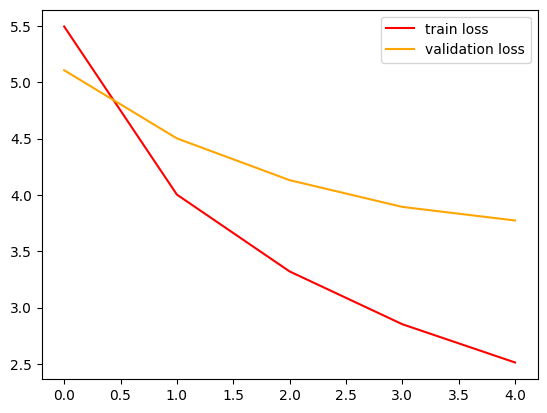

In [ ]:
plt.plot(train_losses,color='red',label='train loss')
plt.plot(valid_losses,color='orange',label='validation loss')
plt.legend()
plt.show()

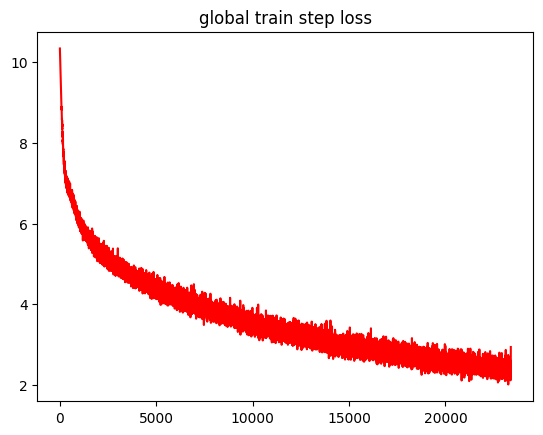

In [ ]:
plt.plot(all_tl,color='red')
plt.title('global train step loss')
plt.show()

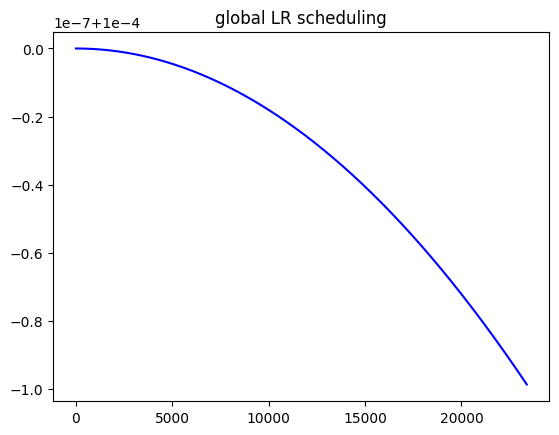

In [ ]:
plt.plot(all_lr,color='blue')
plt.title('global LR scheduling')
plt.show()

In [ ]:
sd = torch.load('./translator/best_model.pt')
model.load_state_dict(sd)
model.eval()

<ipython-input-25-ba528e3ccd8c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load('./translator/best_model.pt')


Seq2SeqTransformer(
  (embedding): Embedding(
    (class_embedding): Embedding(30000, 128)
    (pos_embedding): Embedding(128, 128)
  )
  (encoders): ModuleList(
    (0-7): 8 x EncoderBlock(
      (attn): MultiheadAttention(
        (q): Linear(in_features=128, out_features=128, bias=False)
        (k): Linear(in_features=128, out_features=128, bias=False)
        (v): Linear(in_features=128, out_features=128, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ffd): FeedForward(
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=False)
          (1): Dropout(p=0.1, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=128, bias=False)
        )
      )
      (ln_1): RMSNorm()
      (ln_2): RMSNorm()
    )
  )
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (self_attn): Mul

In [ ]:
with torch.no_grad():
    for i, (src,tgt,lang_id) in enumerate(random.choices(test_samples,k=250)):
        input_ids = bert_tokenizer.encode(f"<s-en>{src}</s>").ids
        input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')
        deterministic = False
        if i > 125:
            deterministic = True
        if lang_id == 'hi':
            bos = bert_tokenizer.token_to_id('<s-hi>')
        else:
            bos = bert_tokenizer.token_to_id('<s-te>')
        if not deterministic:
            temperature = np.random.uniform(0.8,1.2,(1,))[0]
        else:
            temperature = 1.0
        tgt_out = model.generate(input_ids,temperature=temperature,deterministic=deterministic,bos=bos)
        tgt_out = bert_tokenizer.decode(tgt_out.numpy())
        print(f'{deterministic=}, {temperature=:.3f}')
        print(f'\nEN: {src} \n{lang_id.upper()}: {tgt} \n{lang_id.upper()}_MODEL: {tgt_out}\n\n')

deterministic=False, temperature=0.901

EN: Currently, passengers are required to turn off their smartphones, tablets and other devices once a plane's door closes. 
HI: फ़िलहाल, यात्रियों को विमान का द्वार बंद होने पर अपने स्मार्टफोन, टेब्लेट, तथा अन्य डिवाइस को बंद करने की आवश्यकता होती है। 
HI_MODEL: में में चले जा रहे हैं, यूआरएल अव्यरेट अप बुलाओ उनके शरीर पर और अगली तुलनाacle योजनाओं को संवेदनशीलं.


deterministic=False, temperature=1.076

EN: Just in case we caught you in the background. 
HI: सिर्फ मामले में हम पृष्ठभूमि में आप फंस गए. 
HI_MODEL: घर अभिलेख में सम्मान फेकी तरह ।


deterministic=False, temperature=0.882

EN: I have managed to preserve Royce to end so that he knew would be coming. 
HI: मैं आ रहा होगा की रक्षा करने में कामयाब रहे कि Royce समाप्त करने के लिए इतना पता था वह. 
HI_MODEL: मैं चोरी का अंत के लिए जगा करने से बचा लिया जाता था ऐसा हुआ कि वह वह दिल खतरे तक लेने के लिए होगा.


deterministic=False, temperature=1.065

EN: The Laboratory 
TE: ప్రయొగశాల 
TE_MODEL: ద